<a href="https://colab.research.google.com/github/m11dedhia/stock-price-prediction/blob/master/stock_price_prediction_using_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.4 MB/s eta 0:00:00


In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
import pickle

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
data = pd.read_csv('/content/drive/MyDrive/Alda/sp500_stocks_data.csv', index_col='Date', parse_dates=True) # change path according file path of the csv dataset

In [93]:
data.head()
data.shape

(533621, 7)

In [30]:
def get_company_data(symbol):
    company_data = data[data['Symbol'] == symbol]
    company_data = company_data.asfreq(freq='D')
    company_data = company_data.fillna(method='ffill')
    return company_data

In [48]:
def calculate_stationarity(close_col):
  res = adfuller(close_col)
  return res

**GOOGLE**

In [32]:
google = get_company_data('GOOG')
google

,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2010-01-04,GOOG,15.610239,15.610239,15.678981,15.547723,15.615220,78541293.0
2010-01-05,GOOG,15.541497,15.541497,15.637387,15.480475,15.620949,120638494.0
2010-01-06,GOOG,15.149715,15.149715,15.588072,15.102393,15.588072,159744526.0
2010-01-07,GOOG,14.797037,14.797037,15.193053,14.760922,15.178109,257533695.0
2010-01-08,GOOG,14.994298,14.994298,15.024933,14.672753,14.744733,189680313.0
...,...,...,...,...,...,...,...
2024-04-05,GOOG,153.940002,153.940002,154.839996,151.080994,151.679993,16289800.0
2024-04-06,GOOG,153.940002,153.940002,154.839996,151.080994,151.679993,16289800.0
2024-04-07,GOOG,153.940002,153.940002,154.839996,151.080994,151.679993,16289800.0


(1.066754148782803, 0.9949226524277228, 32, 5177, {'1%': -3.431613771563098, '5%': -2.862098454576421, '10%': -2.56706726532591}, 15265.103555702619)


<Axes: xlabel='Date'>

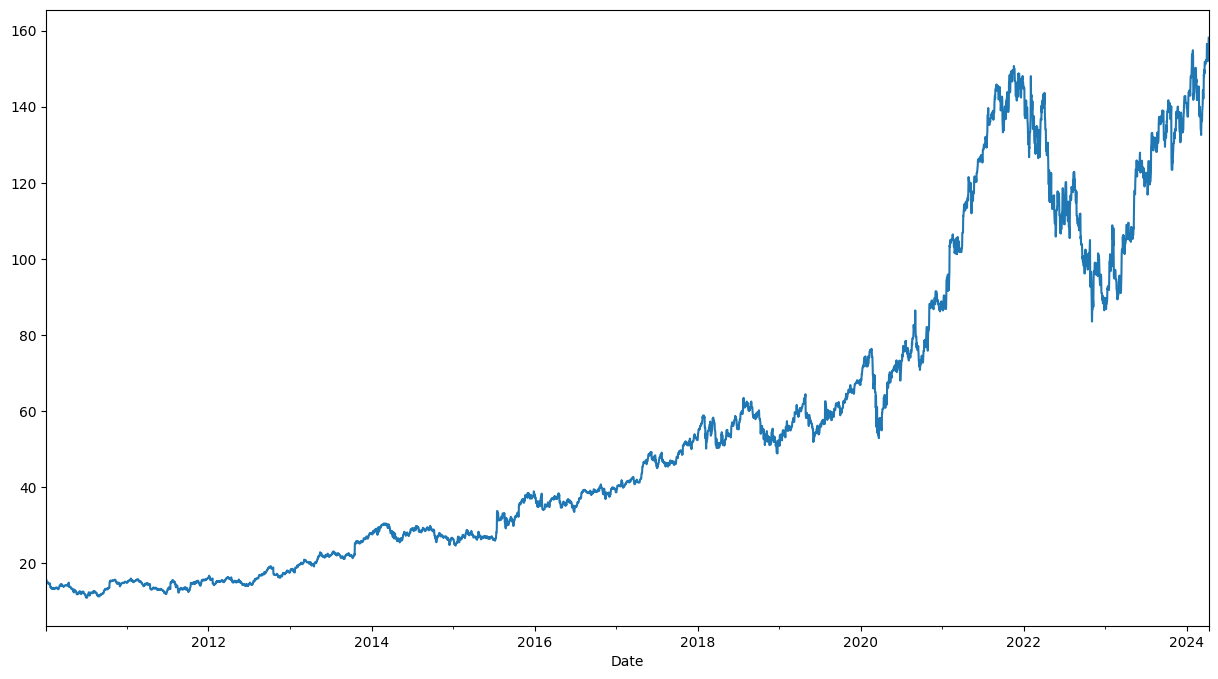

In [33]:
calculate_stationarity(google['Adj Close'])
google['Adj Close'].plot(figsize=(15,8))

In [34]:
d_val = ndiffs(google['Adj Close'], test='adf')
print(d_val)

1


In [35]:
back_test = 22
google_train = google.iloc[:-back_test]
google_test = google.iloc[-back_test:]
train_index = google.index <= google_train.index[-1]
test_index = google.index > google_train.index[-1]

# use to perform hyperparameter tuning

# google_model = pm.auto_arima(google_train['Adj Close'],
#                              d=d_val,
#                              start_p=0,
#                              max_p=10,
#                              start_q=0,
#                              max_q=10,
#                              stepwise=False,
#                              max_order=30,
#                              trace=True)

with open('/content/drive/MyDrive/Alda/arima.pkl', 'rb') as pkl:
    google_model = pickle.load(pkl)

In [36]:
with open('/content/drive/MyDrive/Alda/arima.pkl', 'wb') as pkl:
    pickle.dump(google_model, pkl)

In [37]:
google_model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (9, 1, 10),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 1),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [95]:
def plot_result(model, data, train_data, test_data, col_name, back_test):

    params = model.get_params()
    d = params['order'][1]

    #In sample data prediction
    train_pred = model.predict_in_sample(start=d, end=-1)
    #out of sample prediction
    test_pred, conf = model.predict(n_periods=back_test, return_conf_int=True)

    #plotting real values, fitted values and prediction values
    fig, ax= plt.subplots(figsize=(15,8))
    ax.plot(data[col_name][d-1:].index, data[col_name][d-1:], label='Actual Values')
    ax.plot(train_data.index[d:], train_pred.iloc[-train_data.shape[0]+1:], color='green', label='Fitted Values')
    ax.plot(test_data.index, test_pred, label='Forecast Values')
    ax.fill_between(test_data.index, conf[:,0], conf[:,1], color='red', alpha=0.3)
    ax.legend()

    #evaluating the model using RMSE and MAE metrics
    y_true = test_data[col_name].values
    rmse = np.sqrt(mean_squared_error(y_true,test_pred))
    mae = mean_absolute_error(y_true,test_pred)

    return rmse, mae


Root Mean Squared Error:  5.986660226023348
Mean Absolute Error:  5.3937308820835845


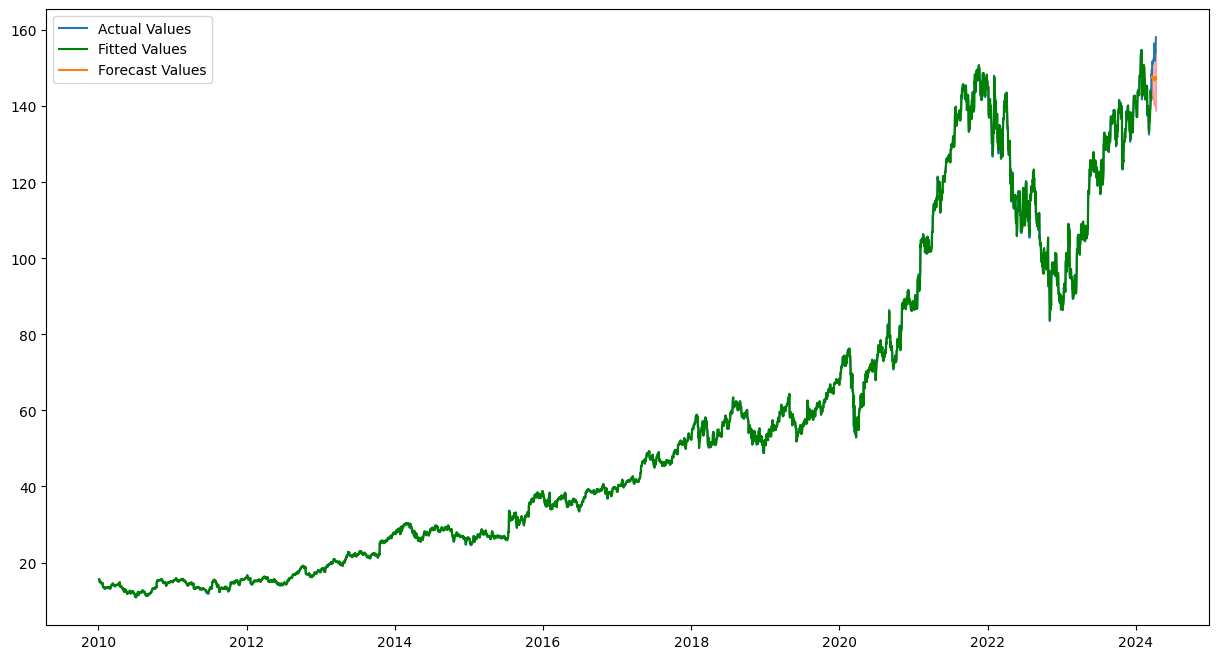

In [39]:
rmse , mae = plot_result(google_model, google, google_train, google_test, 'Adj Close', back_test=22)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)

In [40]:
google_trimmed_train = google_train[google_train.index >= '2023-04-04']
google_trimmed = google[google.index > '2023-04-05']
google_trimmed_train

,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2023-04-04,GOOG,105.120003,105.120003,106.099998,104.599998,104.839996,20377200.0
2023-04-05,GOOG,104.949997,104.949997,106.540001,104.101997,106.120003,21864200.0
2023-04-06,GOOG,108.900002,108.900002,109.629997,104.815002,105.769997,34684200.0
2023-04-07,GOOG,108.900002,108.900002,109.629997,104.815002,105.769997,34684200.0
2023-04-08,GOOG,108.900002,108.900002,109.629997,104.815002,105.769997,34684200.0
...,...,...,...,...,...,...,...
2024-03-14,GOOG,144.339996,144.339996,144.729996,141.485001,142.300003,36117900.0
2024-03-15,GOOG,142.169998,142.169998,144.339996,141.130005,143.410004,41025900.0
2024-03-16,GOOG,142.169998,142.169998,144.339996,141.130005,143.410004,41025900.0


Root Mean Squared Error:  5.986660226023348
Mean Absolute Error:  5.3937308820835845


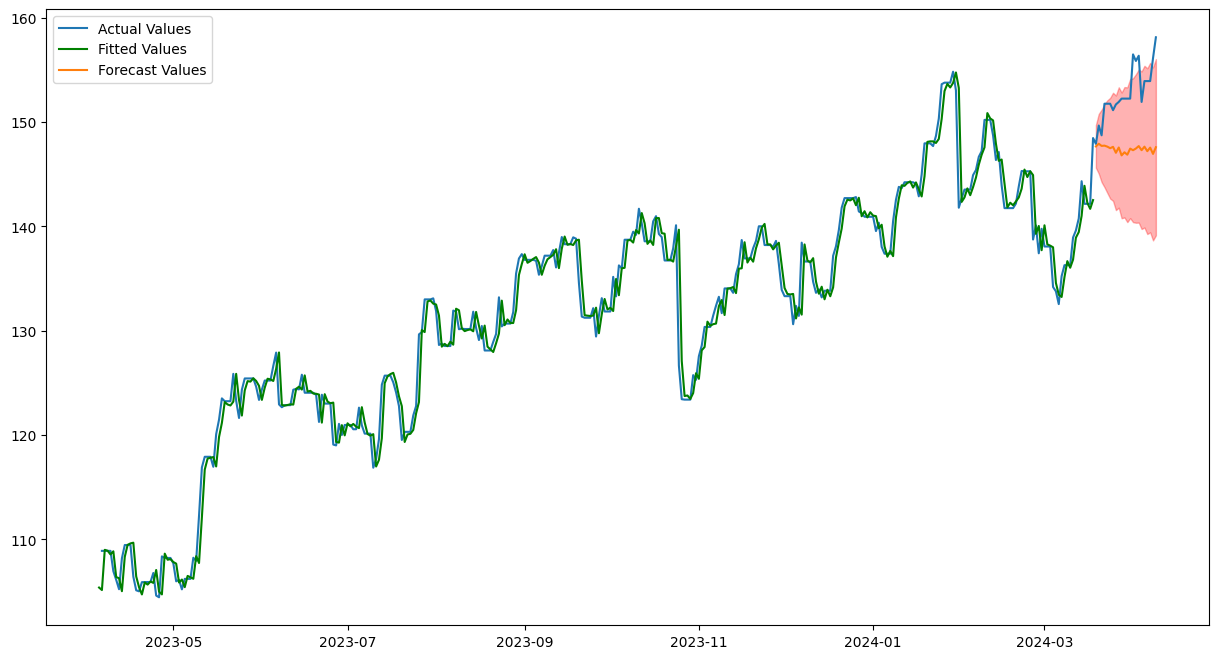

In [41]:
rmse , mae = plot_result(google_model, google_trimmed, google_trimmed_train, google_test, 'Adj Close', back_test=22)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)

Get a list of all companies in the dataset, on which the prediction can be made on

In [42]:
companies = data['Symbol'].unique()
companies

array(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL',
       'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT',
       'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP',
       'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI',
       'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM',
       'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB',
       'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX',
       'BRK-B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG',
       'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF-B', 'BLDR',
       'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL',
       'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC',
       'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB',
       'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME',
       'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED',
  

**Brown & Brown Inc.**

In [94]:
bro = get_company_data('BRO')
bro

,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2010-01-04,BRO,7.657358,9.005000,9.045000,8.930000,9.025000,1437600.0
2010-01-05,BRO,7.602083,8.940000,8.995000,8.850000,8.975000,1702000.0
2010-01-06,BRO,7.534055,8.860000,8.955000,8.815000,8.915000,2378800.0
2010-01-07,BRO,7.538307,8.865000,8.905000,8.800000,8.870000,2139000.0
2010-01-08,BRO,7.500041,8.820000,8.855000,8.780000,8.855000,1130600.0
...,...,...,...,...,...,...,...
2024-04-05,BRO,85.150002,85.150002,85.570000,83.970001,84.139999,1216600.0
2024-04-06,BRO,85.150002,85.150002,85.570000,83.970001,84.139999,1216600.0
2024-04-07,BRO,85.150002,85.150002,85.570000,83.970001,84.139999,1216600.0


(1.3062898937244243, 0.9966439223029943, 21, 5188, {'1%': -3.431611090689047, '5%': -2.862097270162247, '10%': -2.5670666348191573}, 6299.726643567854)


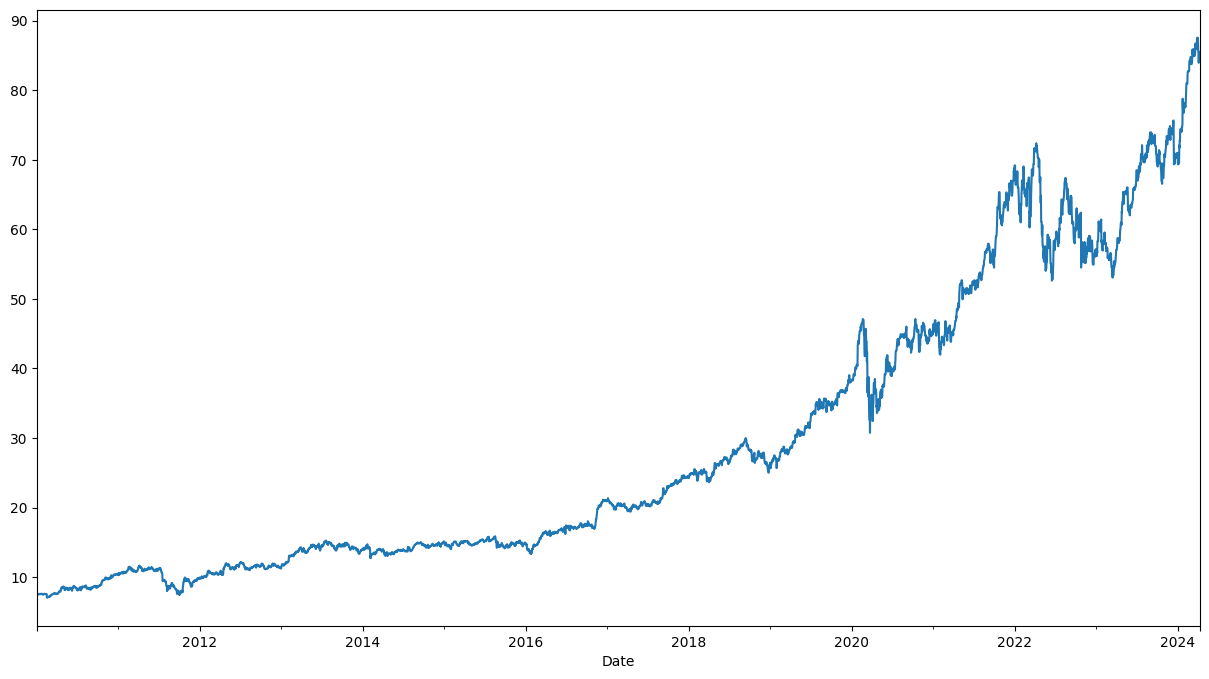

In [44]:
calculate_stationarity(bro['Adj Close'])
bro['Adj Close'].plot(figsize=(15,8))
d_val = ndiffs(bro['Adj Close'], test='adf')

In [89]:
back_test = 22
bro_train = bro.iloc[:-back_test]
bro_test = bro.iloc[-back_test:]
train_index = bro.index <= bro_train.index[-1]
test_index = bro.index > bro_train.index[-1]

bro_model = pm.ARIMA((9,1,10)).fit(bro_train['Adj Close'])

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Squared Error:  1.3145705981041325
Mean Absolute Error:  1.053484077756125


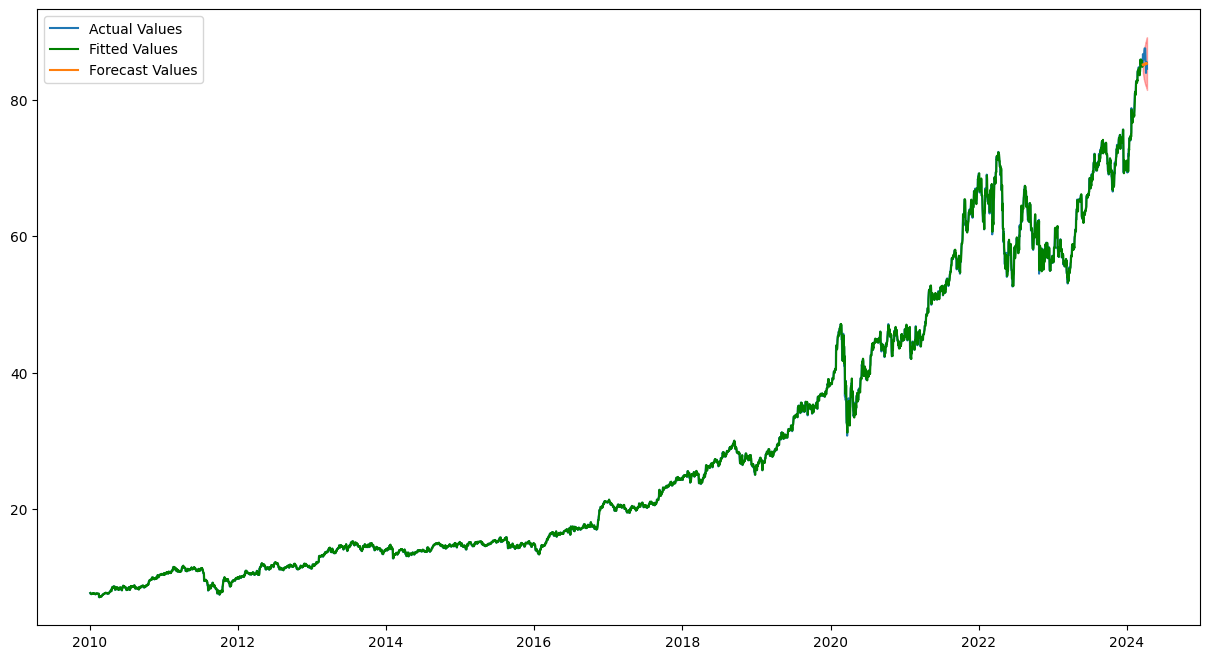

In [90]:
rmse , mae = plot_result(bro_model, bro, bro_train, bro_test, 'Adj Close', back_test=22)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)

In [91]:
bro_trimmed_train = bro_train[bro_train.index >= '2023-04-04']
bro_trimmed = bro[bro.index > '2023-04-05']
bro_trimmed_train

,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2023-04-04,BRO,57.388020,57.790001,58.259998,57.070000,57.970001,1020000.0
2023-04-05,BRO,58.430714,58.840000,58.849998,57.599998,57.599998,1071000.0
2023-04-06,BRO,58.728626,59.139999,59.169998,58.500000,58.810001,799100.0
2023-04-07,BRO,58.728626,59.139999,59.169998,58.500000,58.810001,799100.0
2023-04-08,BRO,58.728626,59.139999,59.169998,58.500000,58.810001,799100.0
...,...,...,...,...,...,...,...
2024-03-14,BRO,84.989998,84.989998,85.830002,84.510002,85.500000,1163300.0
2024-03-15,BRO,84.940002,84.940002,85.150002,83.190002,83.589996,1872300.0
2024-03-16,BRO,84.940002,84.940002,85.150002,83.190002,83.589996,1872300.0


Root Mean Squared Error:  1.3145705981041325
Mean Absolute Error:  1.053484077756125


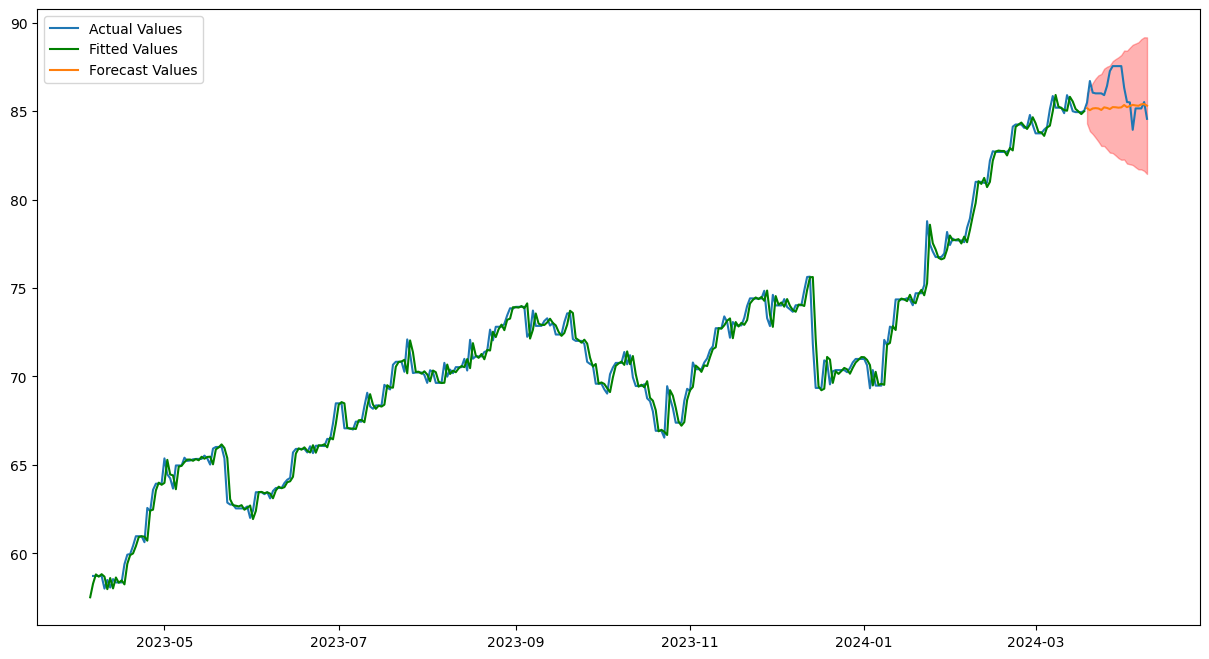

In [92]:
rmse , mae = plot_result(bro_model, bro_trimmed, bro_trimmed_train, bro_test, 'Adj Close', back_test=22)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)

**Function to generate prediction for any stock in the dataset**

In [100]:
def predict_stock_prices_for_a_company(symbol):
  c_data = get_company_data(symbol)
  stationarity = calculate_stationarity(c_data['Adj Close'])
  print(stationarity)
  d = 0
  p = 9
  q = 10
  if stationarity[0] > 1:
    d = ndiffs(c_data['Adj Close'], test='adf')
  back_test = 22 # set to the number of trading days in one month at the minimum
  c_data_train = c_data.iloc[:-back_test]
  c_data_test = c_data.iloc[-back_test:]
  train_index = c_data.index <= c_data_train.index[-1]
  test_index = c_data.index > c_data_train.index[-1]
  c_model = pm.ARIMA((p, d, q)).fit(c_data_train['Adj Close'])
  c_data_trimmed_train = c_data_train[c_data_train.index >= '2023-04-05'] # set to almost a year back
  c_data_trimmed = c_data[c_data.index > '2023-04-05'] # set to one day more than the above date to accomodate one unpredicted day
  rmse , mae = plot_result(c_model, c_data_trimmed, c_data_trimmed_train, c_data_test, 'Adj Close', back_test=back_test)
  print('Root Mean Squared Error: ', rmse)
  print('Mean Absolute Error: ', mae)
  return rmse, mae, c_model

In [ ]:
predict_stock_prices_for_a_company('AAPL')